In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

C:\Users\Lingyu\.conda\envs\tensorflow\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
LABELS = {'primary': 0,
          'clear': 1,
          'agriculture': 2,
          'road': 3,
          'water': 4,
          'partly_cloudy': 5,
          'cultivation': 6,
          'habitation': 7,
          'haze': 8,
          'cloudy': 9,
          'bare_ground': 10,
          'selective_logging': 11,
          'artisinal_mine': 12,
          'blooming': 13,
          'slash_burn': 14,
          'blow_down': 15,
          'conventional_mine': 16}

EVALUATION_PATH = os.path.join(r'../reports/planet_validation')

In [3]:
hashtable = dict([[v,k] for k,v in LABELS.items()])
label_names = list(hashtable.values())

In [4]:
total_size = 40483
train_size = int(np.floor(40483 * 0.8)) + 1
validation_size = total_size - train_size

# 1. Analyze the training set results

## 1.1 Training data labels distribution

In [5]:
labels = np.loadtxt(os.path.join(EVALUATION_PATH, 'out_labels_train.txt'))[0 : train_size, :]
preds = np.loadtxt(os.path.join(EVALUATION_PATH, 'out_predictions_train.txt'))[0 : train_size, :]

primary              30005.0
clear                22759.0
agriculture           9808.0
road                  6434.0
water                 5920.0
partly_cloudy         5804.0
cultivation           3573.0
habitation            2892.0
haze                  2151.0
cloudy                1673.0
bare_ground            680.0
selective_logging      273.0
artisinal_mine         279.0
blooming               277.0
slash_burn             169.0
blow_down               79.0
conventional_mine       79.0
dtype: float64

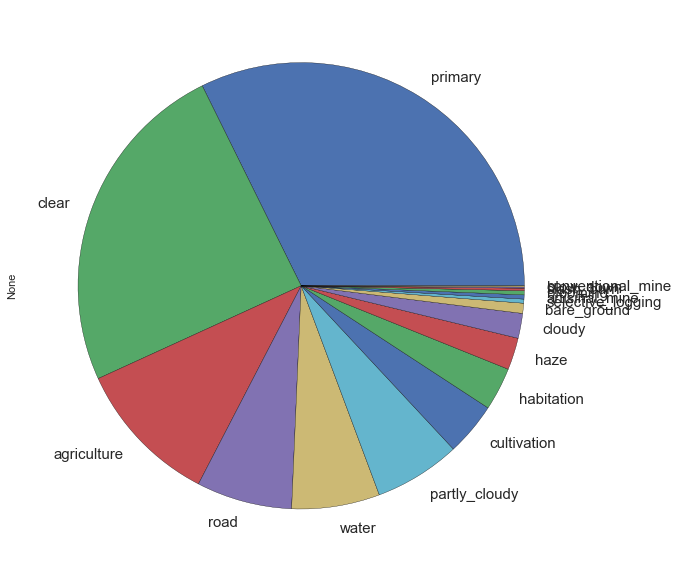

In [6]:
plt.figure(figsize=(10,10))
s = pd.Series(labels.sum(axis=0), index=label_names)
s.plot.pie(fontsize=15)
s

In [7]:
df = pd.DataFrame(preds.reshape(-1, 1), columns=['pred'])
df['label'] = labels.reshape(-1, 1)
df['tag'] = label_names * train_size

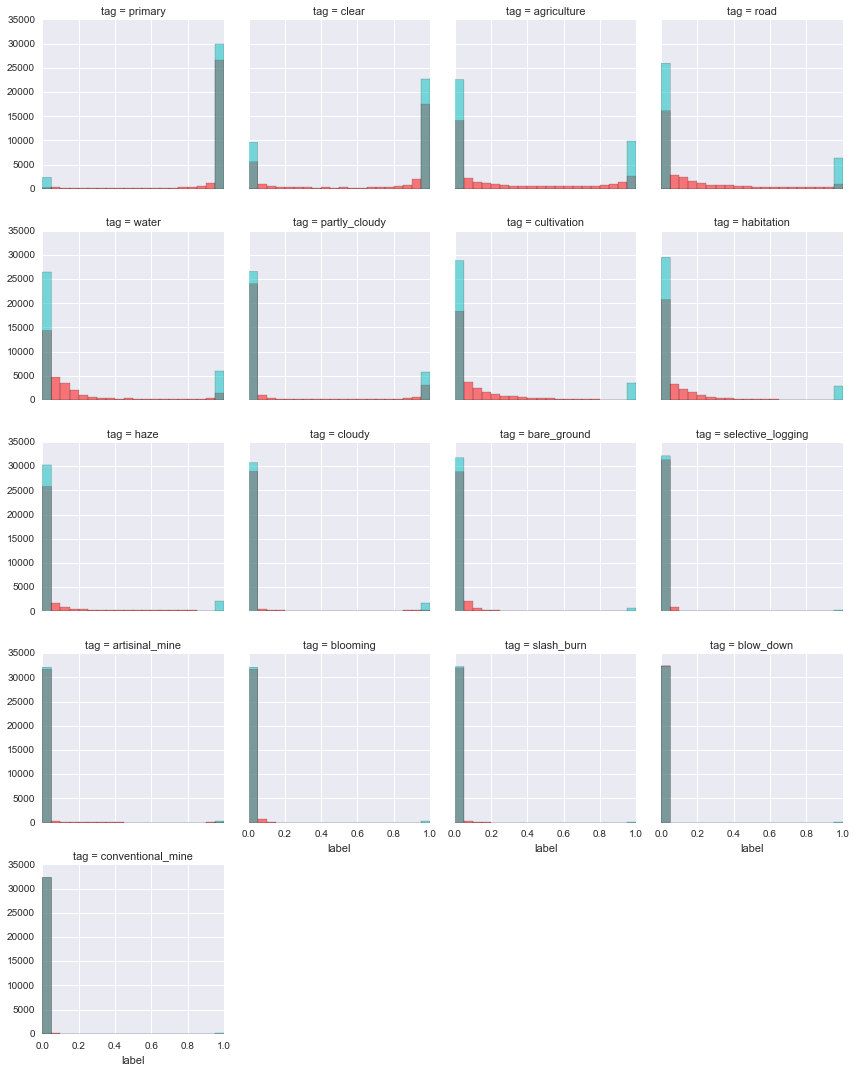

In [8]:
g = sns.FacetGrid(df, col='tag', col_wrap=4)
g = g.map(plt.hist, 'pred', bins=np.arange(0,1.05,0.05), color='r', alpha=0.5)
g = g.map(plt.hist, 'label', bins=np.arange(0,1.05,0.05), color='c', alpha=0.5)

Conclusion: Due to the unbalanced data, the model tends to be conservative, maybe try to oversample the minority labels or add penalty to false negative.

## 1.2 fscore relationship with threshold

In [9]:
thresh_list = np.arange(0, 1.01, 0.01)
fbeta_mat = np.empty((len(thresh_list), len(label_names)))
for idx, thresh in enumerate(thresh_list):
    score = fbeta_score(labels, preds > thresh, beta=2, average=None)
    fbeta_mat[idx, :] = score

C:\Users\Lingyu\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


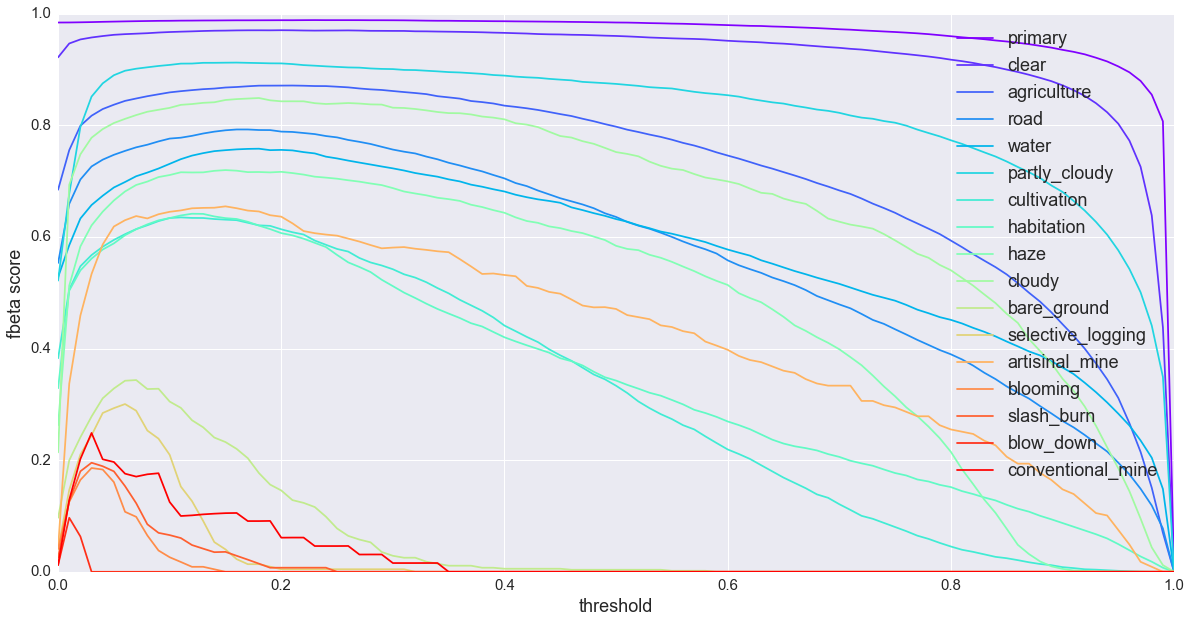

In [10]:
plt.figure(figsize=(20,10))
cm = plt.get_cmap('rainbow')
cm = [cm(i) for i in np.linspace(0,1,17)]
for i in range(len(label_names)):
    plt.plot(thresh_list, fbeta_mat[:, i], color=cm[i])
plt.legend(label_names, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('threshold', fontsize=18)
plt.ylabel('fbeta score', fontsize=18)

conclusion: The fbeta_score for minority labels looks very poor. Also, the optimal thresholds for each labels are not consistent at all.

## 1.3 ROC curve analysis

In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
common_labels = ['primary', 'agriculture', 'road', 'water', 'habitation', 'cultivation', 'bare_ground']
rare_labels = ['selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine']

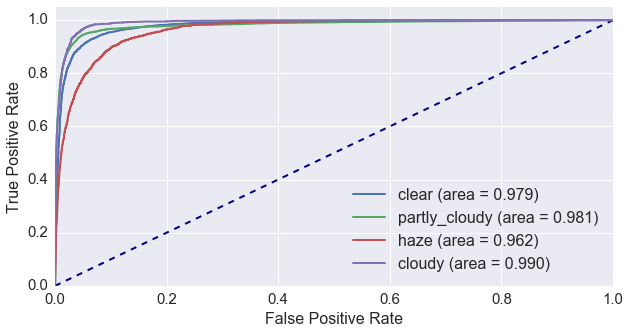

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for idx, label in enumerate(weather_labels):
    fpr[label], tpr[label], _ = roc_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for label in weather_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='{} (area = {:.3f})'.format(label, roc_auc[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower right', fontsize=16)

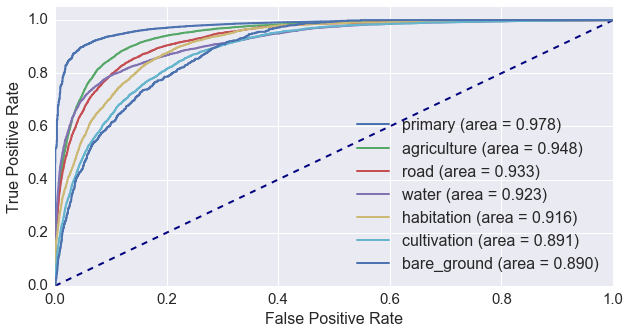

In [13]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for idx, label in enumerate(common_labels):
    fpr[label], tpr[label], _ = roc_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for label in common_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='{} (area = {:.3f})'.format(label, roc_auc[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower right', fontsize=16)

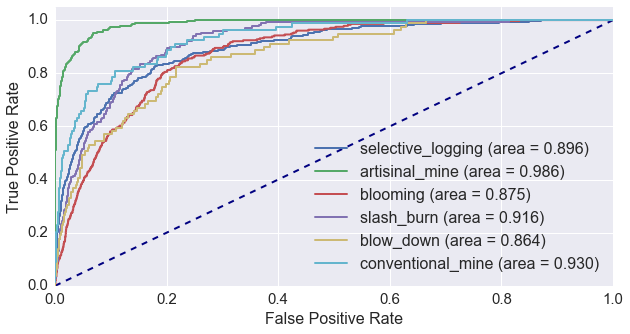

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for idx, label in enumerate(rare_labels):
    fpr[label], tpr[label], _ = roc_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for label in rare_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='{} (area = {:.3f})'.format(label, roc_auc[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower right', fontsize=16)

Conclusion: The ROC curve is unexpectedly good (all of them are higher than 0.85), which is inconsistent with the fscore plot in section 1.2. I think it might be not a good indicator of the network performance.

## 1.4 precision-recall curve analysis

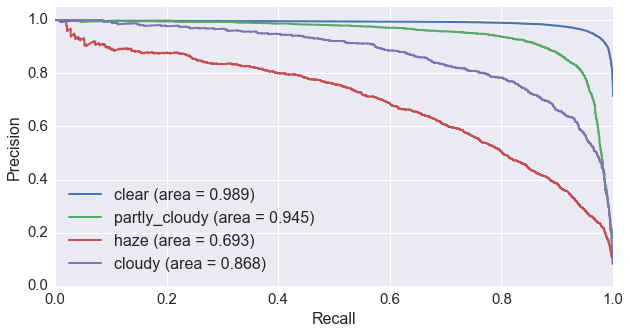

In [15]:
precision = dict()
recall = dict()
average_precision = dict()
for idx, label in enumerate(weather_labels):
    precision[label], recall[label], _ = precision_recall_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    average_precision[label] = average_precision_score(labels[:, LABELS[label]], preds[:, LABELS[label]])

plt.figure(figsize=(10,5))
for label in weather_labels:
    plt.plot(recall[label], precision[label], lw=2, label='{} (area = {:.3f})'.format(label, average_precision[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower left', fontsize=16)

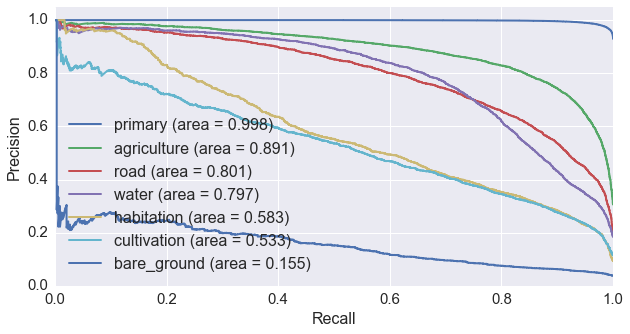

In [16]:
precision = dict()
recall = dict()
average_precision = dict()
for idx, label in enumerate(common_labels):
    precision[label], recall[label], _ = precision_recall_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    average_precision[label] = average_precision_score(labels[:, LABELS[label]], preds[:, LABELS[label]])

plt.figure(figsize=(10,5))
for label in common_labels:
    plt.plot(recall[label], precision[label], lw=2, label='{} (area = {:.3f})'.format(label, average_precision[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower left', fontsize=16)

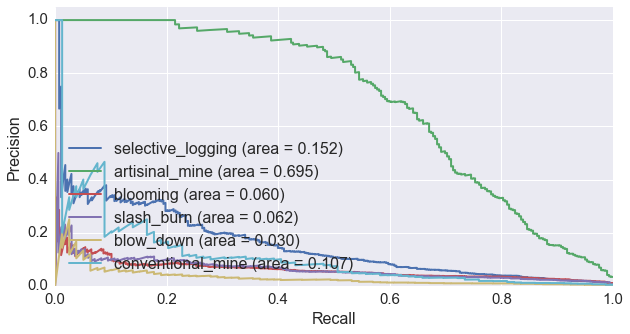

In [17]:
precision = dict()
recall = dict()
average_precision = dict()
for idx, label in enumerate(rare_labels):
    precision[label], recall[label], _ = precision_recall_curve(labels[:, LABELS[label]], preds[:, LABELS[label]])
    average_precision[label] = average_precision_score(labels[:, LABELS[label]], preds[:, LABELS[label]])

plt.figure(figsize=(10,5))
for label in rare_labels:
    plt.plot(recall[label], precision[label], lw=2, label='{} (area = {:.3f})'.format(label, average_precision[label]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower left', fontsize=16)

Conclusion: The Precision-Recall curve is consistent with the analysis in Section 1.1 and Section 1.2. The rare labels classes perform very poorly. I think this curve can be a good indicator of the network performance.